In [23]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation_pd import *
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from support.imu_calculations import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import integrate

In [24]:
_txt_pth = r"test_data\omni_9dof_april_6_2023\sk30_00_rotation\imu01.csv"
_mocap_pth = r"test_data\omni_9dof_april_6_2023\sk30\sk30_00_rotation.csv"

In [25]:
sk_df = pd.read_csv(_txt_pth)
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

# type in marker details
_xm = get_rb_marker_name(1)
_zm = get_rb_marker_name(4)
_om = get_rb_marker_name(3)

"""set zero"""

sk_df = set_zero(sk_df, column_name = ["e_fr"])

sk_df["rust_time"] = sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
sk_df.rename(columns={"rust_time": "time", "e_fr":"enc"}, inplace=True)

In [26]:
_mocap_df.seconds.diff().min()

0.009999999999990905

In [27]:
"""getting angle from non-syncronized data from skateboard df"""
sk_df["ang_y"] = sk_df["enc"].apply(lambda x: x*0.036)
sk_df["diff"] = abs(sk_df["ang_y"].diff())
# replace nan with 0
sk_df["diff"].fillna(0, inplace=True)

# change micros to seconds
# sk_df["seconds"] = sk_df["micros"] / 1000000

# integrate angle
_myval = sk_df["diff"].cumsum()
_new_ang_df, _ = get_orientation(sk_df, "ang_y")
_new_ang_df

,sys_time,time,enc,ang_y,diff,theta
0,2023-04-06 10:02:03.839074,2023-04-06 10:02:03.839510,0,0.000,0.0,0.00000
1,2023-04-06 10:02:03.993572,2023-04-06 10:02:03.993568,0,0.000,0.0,0.00000
2,2023-04-06 10:02:03.993572,2023-04-06 10:02:03.993854,0,0.000,0.0,0.00000
3,2023-04-06 10:02:03.994067,2023-04-06 10:02:03.994110,0,0.000,0.0,0.00000
4,2023-04-06 10:02:03.994067,2023-04-06 10:02:03.994331,0,0.000,0.0,0.00000
...,...,...,...,...,...,...
13749,2023-04-06 10:04:21.359732,2023-04-06 10:04:21.360053,37406,1346.616,0.0,231605.84808
13750,2023-04-06 10:04:21.369900,2023-04-06 10:04:21.370006,37406,1346.616,0.0,231632.78040
13751,2023-04-06 10:04:21.379901,2023-04-06 10:04:21.379921,37406,1346.616,0.0,231659.71272
13752,2023-04-06 10:04:21.389562,2023-04-06 10:04:21.389983,37406,1346.616,0.0,231686.64504


In [28]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()

_m_df[_om["y"]] = savgol_filter(_m_df[_om["y"]], 11, 1)
_m_df[_xm["y"]] = savgol_filter(_m_df[_xm["y"]], 11, 1)
_m_df[_zm["y"]] = savgol_filter(_m_df[_zm["y"]], 11, 1)

_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

100%|██████████| 13188/13188 [00:00<00:00, 127217.63it/s]


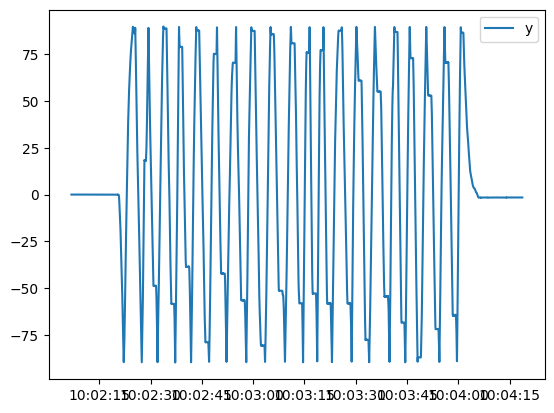

In [29]:
plt.plot(_m_df["time"], _theta_y, label="y")
plt.legend()

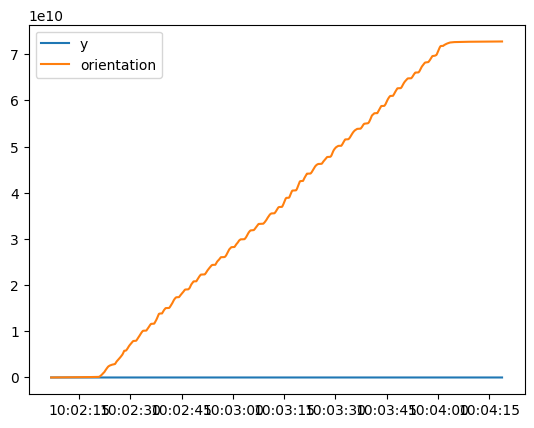

In [30]:
theta_df = pd.DataFrame({"time": _m_df["time"], "theta_y": _theta_y})
theta_df["diff"] = abs(theta_df["theta_y"].diff())
# theta_df["diff"] = theta_df["theta_y"].diff()
# replace nan with 0
theta_df["diff"].fillna(0, inplace=True)
# integrate angle
df, _ = get_orientation(theta_df, "diff")
mocap_orientation = integrate.cumtrapz(theta_df["diff"], theta_df.time, initial=0)
# mocap_orientation = theta_df["diff"].cumsum()*0.02

plt.plot(df["time"], df["theta"], label="y")
plt.plot(theta_df.time, mocap_orientation, label="orientation")
plt.legend()

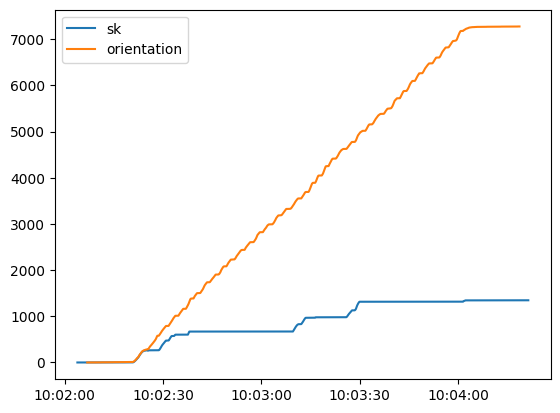

In [31]:
"""plot the angle from skateboard and mocap"""
plt.plot(_new_ang_df["time"], _new_ang_df["ang_y"], label="sk")
# plt.plot(df["time"], df["theta"]*50, label="mc")
plt.plot(theta_df.time, mocap_orientation/10000000, label="orientation")
plt.legend()

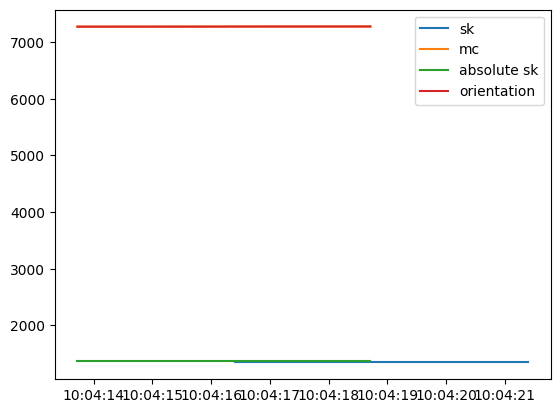

In [32]:
"""plot the angle from skateboard and mocap"""
plt.plot(_new_ang_df["time"][-500:], _new_ang_df["ang_y"][-500:], label="sk")
plt.plot(df["time"][-500:], df["theta"][-500:]*50, label="mc")
plt.plot(df["time"][-500:], _myval[-500:], label = "absolute sk")
plt.plot(theta_df.time[-500:], mocap_orientation[-500:]/10000000, label="orientation")
plt.legend()

In [33]:
_myval.max() - df["theta"].max()*50

-5896.22061135919